# Описание проекта
Вы работаете в фотохостинге для профессиональных фотографов «Со Смыслом» (“With Sense”). 
Ваши пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала.

# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные находятся [здесь](https://st.yandex-team.ru/DS-6856).

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Загрузка библиотек

In [1]:
import os
import re
import pickle
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')


from os.path import exists, isfile, join
from IPython.display import display
from ipywidgets import IntProgress
from matplotlib import pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from PIL import Image


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.applications.resnet import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tqdm.notebook import tqdm, trange

warnings.filterwarnings('ignore')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/bogdanzhylinsky/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bogdanzhylinsky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bogdanzhylinsky/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bogdanzhylinsky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/bogdanzhylinsky/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Загрузка данных

In [2]:
#try:
    #PATH = ('C:/Users/bogda/Desktop/dsplus_integrated_project_4/to_upload')
#except: 
    #PATH = ('/Users/bogdanzhylinsky/Downloads/to_upload')

In [3]:
PATH = '/Users/bogdanzhylinsky/Downloads/to_upload'# загрузка с mac_os
#PATH = 'C:/Users/bogda/Desktop/dsplus_integrated_project_4/to_upload' # загрузка с windows

In [4]:
train_path = join(PATH, 'train_images')
test_path = join(PATH, 'test_images')

In [5]:
def first_look(data: pd.DataFrame, limit_na_category: int = 100) -> None:
    '''Функция получения первичной информации о датафрейме'''
    print ('------------- Рандомные 5 строк ------------')
    display(data.sample(5))
    print('')
    print('')
    print ('---------------- Типы данных ---------------')
    print('')
    print('')
    display(data.info())
    print('')
    print ('----------------- Пропуски -----------------')
    count = 0
    shape_0 = data.shape[0]
    for element in data.columns:
        if data[element].isna().sum() > 0:
            print(element, ' - ', data[element].isna().sum(), 'пропусков ', 
                  round(data[element].isna().sum() * 100 / shape_0,2), '% от числа строк.' )
            count = +1
    if count == 0:
        print('')
        print('')
        print('ПРОПУСКОВ НЕТ')
        print('')
        print('')
    print('')
    print('')
    print ('----------- Количество дубликатов ----------')
    if data.duplicated().sum() > 0:
        print('')
        print('')
        print('ВНИМАНИЕ!!! ОБНАРУЖЕНЫ ДУБЛИКАТЫ: ', data.duplicated().sum(), 'шт.')
    else:
        print('')
        print('')
        print('ДУБЛИКАТЫ ОТСУТСТВУЮТ')
    print('')
    print('')
    print ('----------- Описание данных ----------')
    print('')
    print('')
    display(data.describe())

In [6]:
df_train = pd.read_csv(join(PATH, 'train_dataset.csv'))
df_train = df_train.rename(columns={'query_id': 'annotation_id'})

In [7]:
first_look(df_train)

------------- Рандомные 5 строк ------------


image                annotation_id  \
313   3437654963_c4fdc17e8b.jpg  2534502836_7a75305655.jpg#2   
4553  3439382048_d2e23b2b4c.jpg  3554634863_5f6f616639.jpg#2   
2385  3393343330_b13df4d8ec.jpg  2078311270_f01c9eaf4c.jpg#2   
2091  2498897831_0bbb5d5b51.jpg   925491651_57df3a5b36.jpg#2   
4195  2774430374_fee1d793e7.jpg   326456451_effadbbe49.jpg#2   

                                             query_text  
313   A small brown and white dog running through ta...  
4553  A musician and a crowd next to stage full of m...  
2385        Two women crossing the street on a cold day  
2091                       A tan dog jumps into water .  
4195                             A rottweiler running .



---------------- Типы данных ---------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          5822 non-null   object
 1   annotation_id  5822 non-null   object
 2   query_text     5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None


----------------- Пропуски -----------------


ПРОПУСКОВ НЕТ




----------- Количество дубликатов ----------


ДУБЛИКАТЫ ОТСУТСТВУЮТ


----------- Описание данных ----------




image                annotation_id  \
count                        5822                         5822   
unique                       1000                          977   
top     3364151356_eecd07a23e.jpg  2600867924_cd502fc911.jpg#2   
freq                           10                           34   

                                               query_text  
count                                                5822  
unique                                                977  
top     Two dogs , one brown and white and one black a...  
freq                                                   34

Из таблицы видно, что в тренировочном датасете у нас имеется 1000 изображений. Эти изображения имеют 5822 связи с описаниями, при этом 977 из этих связей являются уникальными. Взглянем на примеры этих фото с описанием.

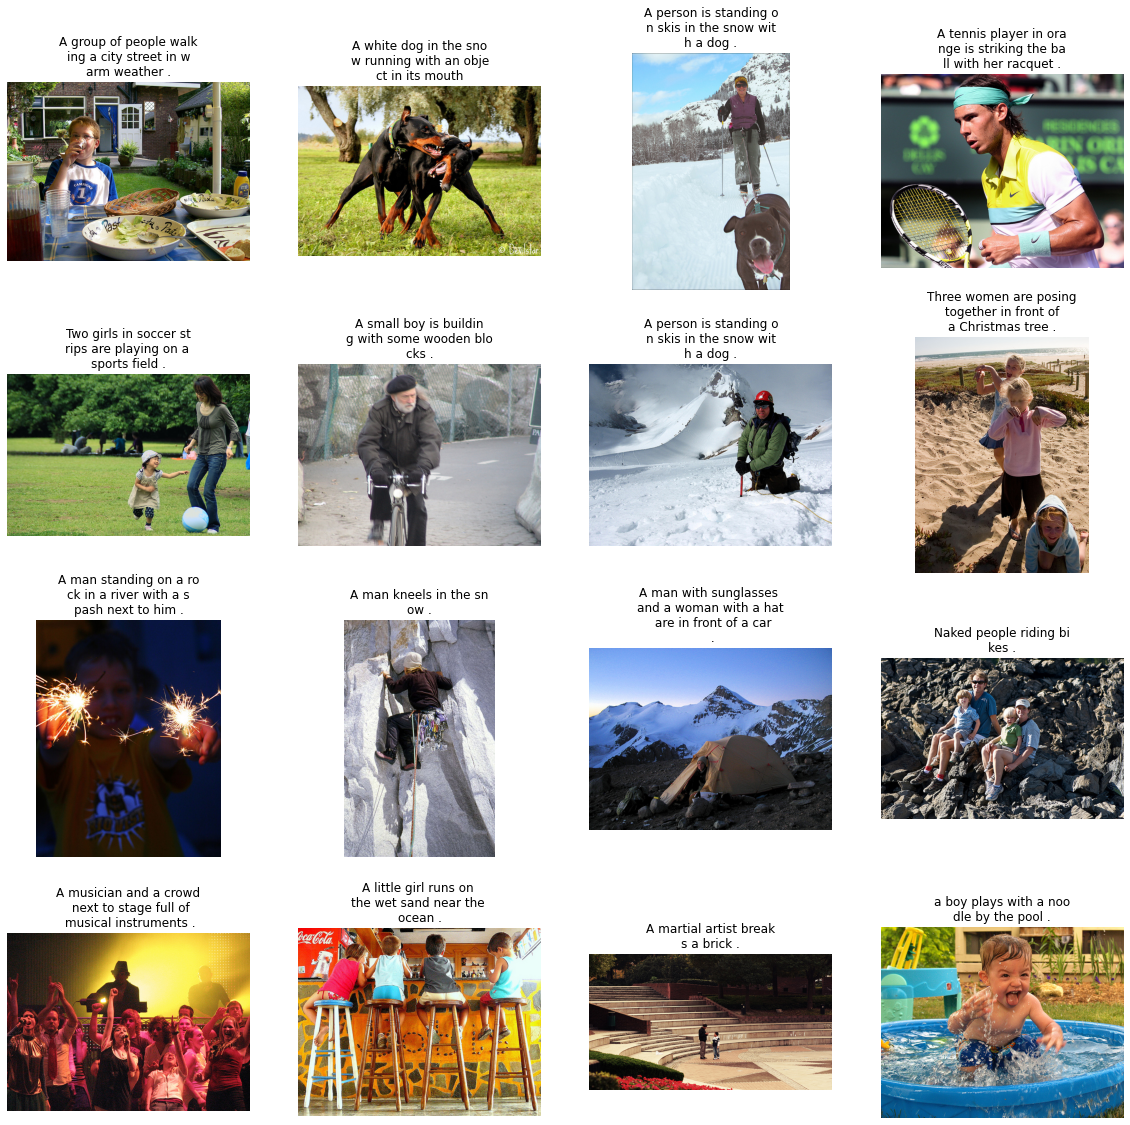

In [8]:
rows = 4
columns = 4

fig = plt.figure(figsize=(20, 20))
count = 1
for _, file, _, query_text in df_train.sample(rows * columns).itertuples():
    img = Image.open(join(train_path, file))
    fig.add_subplot(rows, columns, count)
    count += 1
    plt.imshow(np.array(img))
    plt.axis('off')
    chunks, chunk_size = len(query_text), 22
    plt.title(
        '\n'.join(
            [query_text[i : i + chunk_size] for i in range(0, chunks, chunk_size)]))

Не все фотографии соответствуют описанию или наоборот). Давайте рассмотрим экспертные оценки точности аннотирования фотографий экспертами.

In [9]:
expert_annotations = pd.read_csv(join(PATH, 'ExpertAnnotations.tsv'), sep='\t', header=None)
expert_annotations.columns = ['image', 'annotation_id', 'score_1', 'score_2', 'score_3']

In [10]:
first_look(expert_annotations)

------------- Рандомные 5 строк ------------


image                annotation_id  score_1  \
5225   447111935_5af98563e3.jpg  3108732084_565b423162.jpg#2        1   
5049   375392855_54d46ed5c8.jpg   317488612_70ac35493b.jpg#2        1   
551   1764955991_5e53a28c87.jpg  3263395801_5e4cee2b9e.jpg#2        1   
5275   468102269_135938e209.jpg  2588927489_f4da2f11ec.jpg#2        1   
5783   925491651_57df3a5b36.jpg  1224851143_33bcdd299c.jpg#2        1   

      score_2  score_3  
5225        1        1  
5049        2        2  
551         2        2  
5275        1        1  
5783        1        1



---------------- Типы данных ---------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          5822 non-null   object
 1   annotation_id  5822 non-null   object
 2   score_1        5822 non-null   int64 
 3   score_2        5822 non-null   int64 
 4   score_3        5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None


----------------- Пропуски -----------------


ПРОПУСКОВ НЕТ




----------- Количество дубликатов ----------


ДУБЛИКАТЫ ОТСУТСТВУЮТ


----------- Описание данных ----------




score_1      score_2      score_3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

Оценки экспертов свидетельствуют о низком качестве разметки:

Двое из трех экспертов имеют медианное значение равное 1, что означает, что 50% изображений и их описаний полностью не соответствуют друг другу.
Только один эксперт считает, что в 50% случаев запрос содержит элементы описания изображения, но в целом фотография не соответствует тексту.
Давайте рассмотрим данные о соответствии изображений и описаний, полученные с помощью краудсорсинга.

In [11]:
crowd_annotations = pd.read_csv(join(PATH, 'CrowdAnnotations.tsv'), sep='\t', header=None)
crowd_annotations.columns = ['image', 'crowd_id', 'ratio_ppl_plus', 'count_ppl_plus', 'count_ppl_minus']

In [12]:
first_look(crowd_annotations)

------------- Рандомные 5 строк ------------


image                     crowd_id  ratio_ppl_plus  \
8757   2283966256_70317e1759.jpg  2162564553_96de62c7e6.jpg#2        0.000000   
36751  3538213870_9856a76b2a.jpg  3361990489_92244a58ef.jpg#2        0.000000   
34625  3470951932_27ed74eb0b.jpg  3301811927_a2797339e5.jpg#2        0.000000   
11999  2470486377_c3a39ccb7b.jpg  3262075846_5695021d84.jpg#2        0.000000   
3120   1490670858_e122df2560.jpg  2594042571_2e4666507e.jpg#2        0.333333   

       count_ppl_plus  count_ppl_minus  
8757                0                4  
36751               0                3  
34625               0                3  
11999               0                3  
3120                1                2



---------------- Типы данных ---------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            47830 non-null  object 
 1   crowd_id         47830 non-null  object 
 2   ratio_ppl_plus   47830 non-null  float64
 3   count_ppl_plus   47830 non-null  int64  
 4   count_ppl_minus  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None


----------------- Пропуски -----------------


ПРОПУСКОВ НЕТ




----------- Количество дубликатов ----------


ДУБЛИКАТЫ ОТСУТСТВУЮТ


----------- Описание данных ----------




ratio_ppl_plus  count_ppl_plus  count_ppl_minus
count    47830.000000    47830.000000     47830.000000
mean         0.068786        0.208488         2.820155
std          0.207532        0.628898         0.656676
min          0.000000        0.000000         0.000000
25%          0.000000        0.000000         3.000000
50%          0.000000        0.000000         3.000000
75%          0.000000        0.000000         3.000000
max          1.000000        5.000000         6.000000

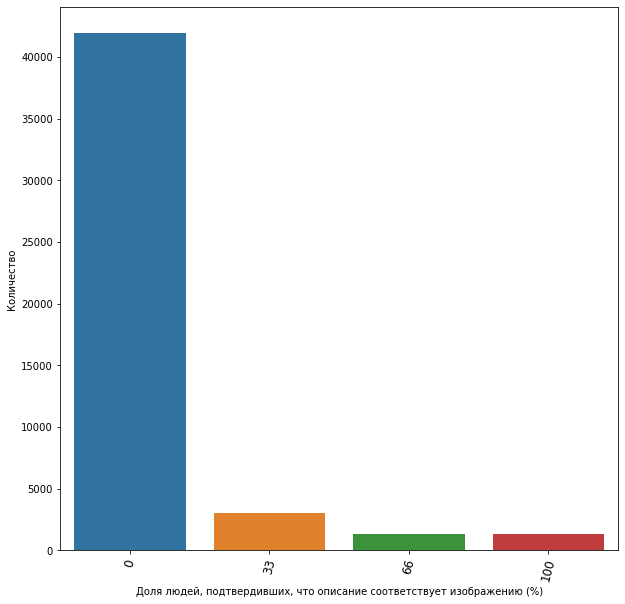

In [13]:
import seaborn as sns
crowd_analicit = crowd_annotations.copy()
crowd_analicit['ratio_ppl_plus'] *= 100
crowd_analicit['ratio_ppl_plus'] = crowd_analicit['ratio_ppl_plus'].astype('int')
crowd_array=[]
fraction_nums = np.array([0, 33, 66, 100])
for i in fraction_nums:
    crowd_array.append((crowd_analicit['ratio_ppl_plus'] == i).sum())
    
plt.figure(figsize=(10, 10))
sns.barplot(x = fraction_nums, y = crowd_array)
plt.xticks(rotation=75, size=12)
plt.xlabel('Доля людей, подтвердивших, что описание соответствует изображению (%)')
plt.ylabel('Количество')
plt.show()

In [14]:
try:
    test_queries = pd.read_csv('/Users/bogdanzhylinsky/Downloads/to_upload/test_queries.csv', sep='|', index_col=0)
except: 
    test_queries = pd.read_csv('C:/Users/bogda/Desktop/dsplus_integrated_project_4/to_upload/test_queries.csv', 
                               sep='|', index_col=0)

In [15]:
first_look(test_queries)

------------- Рандомные 5 строк ------------


query_id  \
277  3247693965_845b3b4349.jpg#2   
476   862177617_c2c0581075.jpg#1   
470   862156271_3eacea90a8.jpg#0   
68   2121140070_a09644550b.jpg#3   
410  3690425778_3b390b3ea5.jpg#0   

                                            query_text  \
277  A dog wrapped with straps is walking away from...   
476      A man wears an interesting blue wig in public   
470  Girls with orange hair standing on the street ...   
68                        kids play ultimate Frisbee .   
410     A man jumps off of a dock and into the water .   

                         image  
277  3247693965_845b3b4349.jpg  
476   862177617_c2c0581075.jpg  
470   862156271_3eacea90a8.jpg  
68   2121140070_a09644550b.jpg  
410  3690425778_3b390b3ea5.jpg



---------------- Типы данных ---------------


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None


----------------- Пропуски -----------------


ПРОПУСКОВ НЕТ




----------- Количество дубликатов ----------


ДУБЛИКАТЫ ОТСУТСТВУЮТ


----------- Описание данных ----------




query_id  \
count                           500   
unique                          500   
top     1177994172_10d143cb8d.jpg#0   
freq                              1   

                                               query_text  \
count                                                 500   
unique                                                500   
top     Two blonde boys , one in a camouflage shirt an...   
freq                                                    1   

                            image  
count                         500  
unique                        100  
top     1177994172_10d143cb8d.jpg  
freq                            5

In [16]:
try:
    test_images = pd.read_csv('C:/Users/bogda/Desktop/dsplus_integrated_project_4/to_upload/test_images.csv')
except: 
    test_images = pd.read_csv('/Users/bogdanzhylinsky/Downloads/to_upload/test_images.csv')

In [17]:
first_look(test_images)

------------- Рандомные 5 строк ------------


image
71   607339469_af851c4119.jpg
54  2714674623_8cd05ac114.jpg
49  3517023411_a8fbd15230.jpg
19  3653484549_f316590b0f.jpg
53  3553476195_fb3747d7c1.jpg



---------------- Типы данных ---------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


None


----------------- Пропуски -----------------


ПРОПУСКОВ НЕТ




----------- Количество дубликатов ----------


ДУБЛИКАТЫ ОТСУТСТВУЮТ


----------- Описание данных ----------




image
count                         100
unique                        100
top     3356748019_2251399314.jpg
freq                            1

В тестовой выборке имеется 100 фотографий, и каждая из них соответствует 500 уникальным описаниям. Таким образом, можно сказать, что каждой фотографии точно соответствуют 5 уникальных описаний.

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

У нас имеется три эксперта, но нам необходимо получить одну оценку. Для этого мы используем метод голосования:

Если два эксперта выставили одинаковую оценку, мы принимаем ее за верную.
Если все три оценки различаются, то такое описание отбрасывается.
Давайте создадим функцию, которая принимает тройку оценок и возвращает оценку, совпадающую хотя бы у двух экспертов. В противном случае, функция вернет "None".

In [18]:
def voting(v1, v2, v3):
    if v1 == v2 or v1 == v3:
        return v1
    elif v2 == v3:
        return v2
    else:
        return None

In [19]:
expert_annotations['experts'] = expert_annotations.apply(
    lambda x: voting(x['score_1'], x['score_2'], x['score_3']), axis=1)
expert_annotations = expert_annotations.dropna(subset=['experts'])
expert_annotations.sample()

image                annotation_id  score_1  score_2  \
2921  307327914_f98f576adb.jpg  1836335410_de8313a64e.jpg#2        2        2   

      score_3  experts  
2921        2      2.0

In [20]:
mm_scaler = MinMaxScaler()#масшитабирование

Мы заинтересованы только в относительно соответствующих друг другу изображениях и описаниях, поэтому мы исключим комбинации, для которых экспертная оценка ниже 0,5.

In [21]:
mm_scaler = MinMaxScaler()
expert_annotations["experts"] = mm_scaler.fit_transform(expert_annotations[["experts"]])
expert_annotations = expert_annotations.drop(
    expert_annotations[expert_annotations["experts"] < 0.5].index, axis=0)
expert_annotations.shape

(803, 6)

In [22]:
df_train = (df_train.set_index(['image', 'annotation_id']).join(
    expert_annotations.set_index(['image', 'annotation_id'])[['experts']], how='inner',).reset_index()) #объединение

## Векторизация изображений

In [23]:
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    cnn = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    model = Sequential()
    model.add(cnn)
    model.add(GlobalAveragePooling2D())
    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mae'])

    return model

In [24]:
def image_to_array(file: str, path: str = train_path, wh: int = 224, ht: int = 224):
    img = image.load_img(join(path, file), target_size=(wh, ht))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [25]:
model = create_model((224, 224, 3))

2023-07-05 17:28:57.165254: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Векторизация текстов

### Лемматизируем описания фотографий

In [26]:
def process_text(text):
    def clear_text(text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z]', ' ', text)   
        text = ' '.join(text.split())
        return text
    
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,               
                    "N": wordnet.NOUN,              
                    "V": wordnet.VERB,              
                    "R": wordnet.ADV                
                   }  
        return tag_dict.get(tag, wordnet.NOUN)

    lemmatizer = WordNetLemmatizer()

    def lemm_text(text):
        text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
        return ' '.join(text)
    
    text = clear_text(text)
    text = lemm_text(text)
    
    return text

print("Исходный текст:", df_train.query_text[1]) 
print("Лемматизированный текст:", process_text(df_train.query_text[1]))

Исходный текст: A girl wearing a yellow shirt and sunglasses smiles .
Лемматизированный текст: a girl wear a yellow shirt and sunglass smile


In [27]:
stop_words = set(stopwords.words('english'))

In [28]:
%%time
df_train['lemm_query'] = df_train['query_text'].apply(process_text) 

CPU times: user 1.09 s, sys: 90.7 ms, total: 1.18 s
Wall time: 1.18 s


In [29]:
df_train

image                annotation_id  \
0    2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
1    2718495608_d8533e3ac5.jpg  2718495608_d8533e3ac5.jpg#2   
2     700884207_d3ec546494.jpg  2718495608_d8533e3ac5.jpg#2   
3    2370481277_a3085614c9.jpg  3545652636_0746537307.jpg#2   
4    2913965136_2d00136697.jpg  3545652636_0746537307.jpg#2   
..                         ...                          ...   
798  3507076266_8b17993fbb.jpg  3507076266_8b17993fbb.jpg#2   
799   542317719_ed4dd95dc2.jpg   542317719_ed4dd95dc2.jpg#2   
800   758921886_55a351dd67.jpg   542317719_ed4dd95dc2.jpg#2   
801   396360611_941e5849a3.jpg  2162564553_96de62c7e6.jpg#2   
802   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   

                                            query_text   experts  \
0    A young child is wearing blue goggles and sitt...  1.000000   
1    A girl wearing a yellow shirt and sunglasses s...  1.000000   
2    A girl wearing a yellow shirt and sunglasses s...  0.666667   
3    A young boy dressed in a red uniform kicks the...  0.666667   
4    A young boy dressed in a red uniform kicks the...  0.666667   
..                                                 ...       ...   
798            Man in brown jacket leading black horse  1.000000   
799  A smiling child slides down a slippery tube slide  1.000000   
800  A smiling child slides down a slippery tube slide  1.000000   
801  A shirtless man in a pink hat stands on a rock...  0.666667   
802                       A blurry photo of two dogs .  0.666667   

                                            lemm_query  
0    a young child be wear blue goggles and sit in ...  
1        a girl wear a yellow shirt and sunglass smile  
2        a girl wear a yellow shirt and sunglass smile  
3    a young boy dress in a red uniform kick the so...  
4    a young boy dress in a red uniform kick the so...  
..                                                 ...  
798               man in brown jacket lead black horse  
799     a smile child slide down a slippery tube slide  
800     a smile child slide down a slippery tube slide  
801  a shirtless man in a pink hat stand on a rocky...  
802                          a blurry photo of two dog  

[803 rows x 5 columns]

Для блокировки запрещённых фотографий мы выполним следующие задачи:

- Составление списка слов, используемых в английском языке для обозначения детей и подростков.
- Написание функции, которая будет искать эти слова в лемматизированных текстах.

In [30]:
child_stop = [
    "boy",
    "girl",
    "child",
    "baby",
    "kid",
    "babe",
    "infant",
    "teenager",
    "teeny",
    "juvenile",
    "teener",
    "stripling"]

In [31]:
def chld_text(text: str) -> bool:
    res = False
    for w in child_stop:
        res |= text.lower().find(w) > -1
    return res

In [32]:
df_train['child'] = df_train.apply(
    lambda x: chld_text(x['lemm_query']), axis=1)

In [33]:
child_images = set(df_train[df_train['child'] == True]['image'])

In [34]:
df_train = df_train.drop(df_train[df_train['image'].isin(child_images)].index, axis=0)

In [35]:
df_train.shape

(646, 6)

Осталось без 'детей' 646 описаний.

## Объединение векторов

In [36]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(
    gss.split(
        X=df_train.drop(columns=['annotation_id']),
        y=df_train['annotation_id'],
        groups=df_train['image']))
train_df, valid_df = df_train.iloc[train_indices], df_train.iloc[test_indices]

In [37]:
# Векторы изображения
image_vec = pd.DataFrame(index=df_train['image'].unique(), columns=['image_vector']).reset_index() 

In [38]:
image_vec.columns = ['image', 'image_vector']

In [39]:
%%time
image_vec['image_vector'] = image_vec.apply(
    lambda x: tf.cast(model(image_to_array(x['image'])), dtype=np.float64), axis=1)

CPU times: user 2min 33s, sys: 1min 12s, total: 3min 45s
Wall time: 1min 8s


In [40]:
image_vector_size = image_vec.loc[0, 'image_vector'].shape[1]
image_vector_size

2048

In [41]:
# Векторы текста
tfvect_short = TfidfVectorizer(stop_words=stop_words)
tf_matrix_short = tfvect_short.fit_transform(train_df['lemm_query'])
tf_matrix_short.todense().shape

(463, 423)

In [42]:
tfvect = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2))
tf_matrix = tfvect.fit_transform(train_df['lemm_query'])
tf_matrix.todense().shape

(463, 1304)

In [43]:
train_df['query_vector'] = tf_matrix.todense().tolist()
train_df['query_vector'] = train_df['query_vector'].apply(lambda x: tf.convert_to_tensor([x], dtype=np.float64))

In [44]:
tf_matrix = tfvect.transform(valid_df['lemm_query'])
valid_df['query_vector'] = tf_matrix.todense().tolist()
valid_df['query_vector'] = valid_df['query_vector'].apply(lambda x: tf.convert_to_tensor([x], dtype=np.float64))

In [45]:
text_vector_size = train_df.loc[df_train.index[0], 'query_vector'].shape[1]

In [46]:
# Объединение векторов
train_df = train_df.merge(image_vec, on='image', how='left')
valid_df = valid_df.merge(image_vec, on='image', how='left')

## Обучение модели предсказания соответствия

### Линейная регрессия

Подготовка данных

In [47]:
X_train = train_df[['annotation_id', 'query_vector']]
y_train = train_df[['image', 'image_vector']]
X_valid = valid_df[['annotation_id', 'query_vector']]
y_valid = valid_df[['image', 'image_vector']]

In [48]:
X = tf.stack(X_train['query_vector'])
Y = tf.stack(y_train['image_vector'])

In [49]:
X_val = tf.stack(X_valid['query_vector'])

In [50]:
X.shape, Y.shape

(TensorShape([463, 1, 1304]), TensorShape([463, 1, 2048]))

Cоздание случайных значений для вектора весов W и смещения b.

In [51]:
W = tf.Variable(np.random.randn(text_vector_size, image_vector_size), name='W')
b = tf.Variable(np.random.randn(1, image_vector_size), name='b')

In [52]:
W.shape, b.shape

(TensorShape([1304, 2048]), TensorShape([1, 2048]))

Параметры для Логистической регрессиии

In [53]:
learning_rate = 0.01
epochs = 250
dMSE = 1e-3

In [54]:
def y_pred(x):
    return tf.add(tf.linalg.matmul(x, W), b)

def cost(x=X, y=Y):
    cost = tf.reduce_sum(tf.pow(y_pred(x) - y, 2)) / (2 * image_vector_size)
    return cost

optimizer = tf.keras.optimizers.Adam(learning_rate)

In [55]:
pred = y_pred(X)
trainable_vars = [W, b]

MSE (Mean Squared Error) является распространенной метрикой для оценки качества моделей в задачах компьютерного зрения, включая поиск изображения по запросу. Чувствительность к различиям: MSE измеряет среднеквадратичное отклонение между предсказанными и истинными значениями. В контексте поиска изображений, это означает, что MSE будет учитывать даже малые различия в пиксельных значениях между предсказанным и целевым изображением. Это полезно, поскольку поиск изображения по запросу требует высокой точности и воспроизводимости.

#### Обучение

In [56]:
%%time
c_old = tf.constant(200, np.float64)
for epoch in tqdm(range(epochs)):
    optimizer.minimize(cost, trainable_vars)
    pred = y_pred(X)
    if (epoch + 1) % 5 == 0:
        c = cost()
        print("Epoch", (epoch + 1), ": cost =", c.numpy())
        err = (c_old - c) / c
        if abs(err) < dMSE:
            print(f"Relative error: {err}")
            break

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5 : cost = 607.5490673092706
Epoch 10 : cost = 523.833967674005
Epoch 15 : cost = 452.64117915277825
Epoch 20 : cost = 392.70345564811555
Epoch 25 : cost = 342.5270723281787
Epoch 30 : cost = 300.6242075116815
Epoch 35 : cost = 265.6366608083436
Epoch 40 : cost = 236.37991517834715
Epoch 45 : cost = 211.8490910417343
Epoch 50 : cost = 191.2065361641436
Epoch 55 : cost = 173.76268928650023
Epoch 60 : cost = 158.95444744864147
Epoch 65 : cost = 146.32384522740531
Epoch 70 : cost = 135.49884653554466
Epoch 75 : cost = 126.17702213859238
Epoch 80 : cost = 118.11203500079671
Epoch 85 : cost = 111.10269216047661
Epoch 90 : cost = 104.98410901098715
Epoch 95 : cost = 99.62061997283865
Epoch 100 : cost = 94.90013198923617
Epoch 105 : cost = 90.72963906400726
Epoch 110 : cost = 87.03163514207033
Epoch 115 : cost = 83.74124610521942
Epoch 120 : cost = 80.80393320959232
Epoch 125 : cost = 78.1736465834764
Epoch 130 : cost = 75.81133740631758
Epoch 135 : cost = 73.6837556536765
Epoch 140 : c

MSE на тренировочной выборке составила ~ 54 
Мы успешно обучили регрессию, что позволяет нам теперь преобразовывать векторы описаний в векторы изображений и находить изображения, наиболее близкие к заданным запросам. Для этого необходимо реализовать функцию, которая вычисляет расстояние между двумя векторами. После этого остается только выбрать наиболее близкие векторы. Однако перед этим необходимо проверить качество прогноза или преобразования на валидационной выборке.

Для вычисления расстояния между векторами по умолчанию используется евклидово расстояние.

In [57]:
def vec_distance(A: tf.Tensor, B: tf.Tensor, ord: str = 'euclidean') -> float:
    return tf.norm(B - A, axis=-1, ord=ord).numpy()[0]

Функция поиска в заданной серии векторов, наиболее близких к запросу. Функция возвращает имена файлов:

In [58]:
def find_image_LR(query_vector, ivecs, lim=3):
    iv = y_pred(query_vector)
    df = ivecs.copy()
    for i in df.index:
        df.loc[i, 'dist'] = vec_distance(iv, df.loc[i, 'image_vector'])
    return df.sort_values(by='dist')['image'].unique()[:lim]

Функция отображения изображения из списка, соответсвующие запросу:

In [59]:
def show_images(query, images, path=train_path, rows=1, columns=3):
    fig = plt.figure(figsize=(12, 12))
    print(query)
    count = 1
    for file in images:
        img = Image.open(join(path, file))
        fig.add_subplot(rows, columns, count)
        count += 1
        plt.imshow(np.array(img))
        plt.axis('off')

Для облегчения использования, объединим предыдущие функции в одну:

- Принимает индекс из валидационной выборки.
- Извлекает из выборки запрос и соответствующий ему вектор.
- Строит прогноз.
- Выводит результат.

In [60]:
def predict_LR(idx):
    qv = X_valid.loc[idx, 'query_vector']
    qt = valid_df[valid_df['annotation_id'] == X_valid.loc[idx, 'annotation_id']]['query_text'].iloc[0]
    images = find_image_LR(qv, y_valid)
    show_images(qt, images)

A crowd of people at an outdoor event


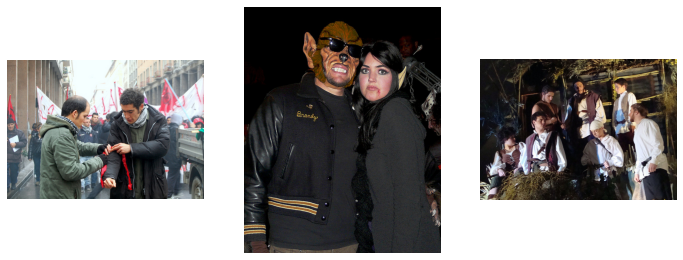

In [61]:
predict_LR(10)

Two dogs run through a field .


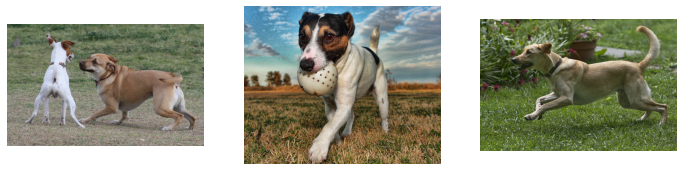

In [62]:
predict_LR(110)

Линейная регрессия в целом успешно выполняет свою работу: она не углубляется в детали, но в целом достаточно справляется со своей задачей.

## Нейронная сеть

#### Подготовка данных

In [63]:
X_nn = tf.cast(tf.reshape(X, (X.shape[0], X.shape[2])), dtype=np.float64)#
Y_nn = tf.cast(tf.reshape(Y, (Y.shape[0], Y.shape[2])), dtype=np.float64)#

In [64]:
X_nn_val = tf.stack(X_valid['query_vector'])
Y_nn_val = tf.stack(y_valid['image_vector'])
X_nn_val = tf.cast(tf.reshape(X_nn_val, (X_nn_val.shape[0], X_nn_val.shape[2])), dtype=np.float64)#
Y_nn_val = tf.cast(tf.reshape(Y_nn_val, (Y_nn_val.shape[0], Y_nn_val.shape[2])), dtype=np.float64)#

#### Создание модели

In [65]:
def create_nn_model(dout=0.5):
    optimizer = Adam()
    model = Sequential()
    model.add(
        Dense(text_vector_size, activation='relu'))
    if dout > 0:
        model.add(Dropout(dout))
    model.add(Dense(text_vector_size // 2, activation='relu'))
    if dout > 0:
        model.add(Dropout(dout))
    model.add(Dense(text_vector_size // 4, activation='relu'))
    model.add(Dense(image_vector_size, activation='relu'))
    model.compile(
        optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

    return model

In [66]:
nn_model = create_nn_model()

#### Обучение

In [67]:
%%time
nn_learn = nn_model.fit(
    tf.cast(X, dtype=np.float32),
    tf.cast(Y, dtype=np.float32),
    batch_size=100,
    epochs=100,
    validation_data=(X_nn_val, Y_nn_val))

Epoch 1/100
5/5 [==============================] - 1s 78ms/step - loss: 1.0114 - mse: 1.0114 - val_loss: 0.8825 - val_mse: 0.8825
Epoch 2/100
5/5 [==============================] - 0s 34ms/step - loss: 0.8000 - mse: 0.8000 - val_loss: 0.7054 - val_mse: 0.7054
Epoch 3/100
5/5 [==============================] - 0s 32ms/step - loss: 0.6902 - mse: 0.6902 - val_loss: 0.6851 - val_mse: 0.6851
Epoch 4/100
5/5 [==============================] - 0s 31ms/step - loss: 0.6775 - mse: 0.6775 - val_loss: 0.6665 - val_mse: 0.6665
Epoch 5/100
5/5 [==============================] - 0s 32ms/step - loss: 0.6558 - mse: 0.6558 - val_loss: 0.6590 - val_mse: 0.6590
Epoch 6/100
5/5 [==============================] - 0s 36ms/step - loss: 0.6448 - mse: 0.6448 - val_loss: 0.6482 - val_mse: 0.6482
Epoch 7/100
5/5 [==============================] - 0s 35ms/step - loss: 0.6424 - mse: 0.6424 - val_loss: 0.6504 - val_mse: 0.6504
Epoch 8/100
5/5 [==============================] - 0s 38ms/step - loss: 0.6374 - mse: 0.63

Epoch 61/100
5/5 [==============================] - 0s 36ms/step - loss: 0.3896 - mse: 0.3896 - val_loss: 0.5774 - val_mse: 0.5774
Epoch 62/100
5/5 [==============================] - 0s 35ms/step - loss: 0.3861 - mse: 0.3861 - val_loss: 0.5854 - val_mse: 0.5854
Epoch 63/100
5/5 [==============================] - 0s 33ms/step - loss: 0.3865 - mse: 0.3865 - val_loss: 0.5780 - val_mse: 0.5780
Epoch 64/100
5/5 [==============================] - 0s 34ms/step - loss: 0.3812 - mse: 0.3812 - val_loss: 0.5829 - val_mse: 0.5829
Epoch 65/100
5/5 [==============================] - 0s 33ms/step - loss: 0.3810 - mse: 0.3810 - val_loss: 0.5803 - val_mse: 0.5803
Epoch 66/100
5/5 [==============================] - 0s 34ms/step - loss: 0.3782 - mse: 0.3782 - val_loss: 0.5879 - val_mse: 0.5879
Epoch 67/100
5/5 [==============================] - 0s 33ms/step - loss: 0.3774 - mse: 0.3774 - val_loss: 0.5822 - val_mse: 0.5822
Epoch 68/100
5/5 [==============================] - 0s 32ms/step - loss: 0.3760 - m

В итоге, на валидационной выборке значение MSE близкое к линейной регрессии: но все-таки чуть хуже 0.61, но обучилась нейросеть гораздо быстрее

In [68]:
def find_image_NN(query_vector, ivecs, lim=3):
    iv = nn_model.predict(query_vector)
    df = pd.DataFrame(ivecs)
    for i in df.index:
        df.loc[i, 'dist'] = vec_distance(iv, df.loc[i, 'image_vector'])
    return df.sort_values(by='dist')['image'].unique()[:lim]

In [69]:
def predict_NN(idx, df=y_valid):
    qv = X_valid.loc[idx, 'query_vector']
    qt = valid_df[valid_df['annotation_id'] == X_valid.loc[idx, 'annotation_id']]['query_text'].iloc[0]
    images = find_image_NN(qv, df)
    show_images(qt, images)

A crowd of people at an outdoor event


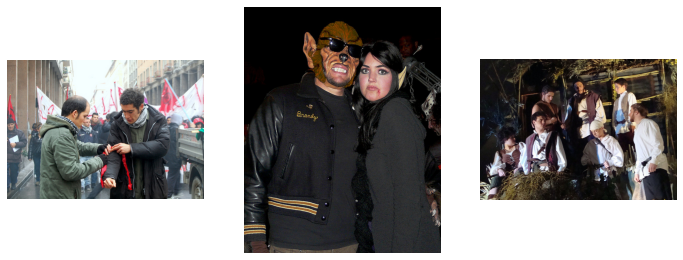

In [70]:
predict_NN(10)

Two dogs run through a field .


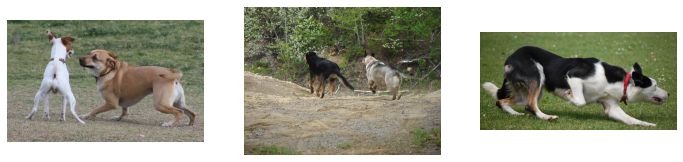

In [71]:
predict_NN(110)

### Вывод

Обе модели обладают сравнимой предсказательной способностью, однако нейросеть удивительно быстро обучается по сравнению с регрессией.

## Тестирование модели

In [72]:
%%time
test_images['image_vector'] = test_images.apply(
    lambda x: tf.cast(model(image_to_array(x['image'], test_path)), dtype=np.float64),axis=1)

CPU times: user 42.8 s, sys: 20.2 s, total: 1min 3s
Wall time: 19.4 s


In [73]:
%%time
test_queries['lemm_query'] = test_queries['query_text'].apply(process_text)

CPU times: user 866 ms, sys: 155 ms, total: 1.02 s
Wall time: 1.09 s


In [74]:
%%time
tf_matrix_test = tfvect.transform(test_queries['lemm_query'])
test_queries['query_vector'] = tf_matrix_test.todense().tolist()
test_queries['query_vector'] = test_queries['query_vector'].apply(
    lambda x: tf.reshape(tf.convert_to_tensor(x, dtype=np.float64),(1, text_vector_size)))

CPU times: user 321 ms, sys: 19.7 ms, total: 341 ms
Wall time: 342 ms


In [75]:
test_queries.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  \
0  1177994172_10d143cb8d.jpg   
1  1177994172_10d143cb8d.jpg   
2  1177994172_10d143cb8d.jpg   
3  1177994172_10d143cb8d.jpg   
4  1177994172_10d143cb8d.jpg   

                                          lemm_query  \
0  two blonde boy one in a camouflage shirt and t...   
1          two boy be squirt water gun at each other   
2                two boy spray each other with water   
3     two child wear jean squirt water at each other   
4        two young boy be squirt water at each other   

                                        query_vector  
0  ((tf.Tensor(0.0, shape=(), dtype=float64), tf....  
1  ((tf.Tensor(0.0, shape=(), dtype=float64), tf....  
2  ((tf.Tensor(0.0, shape=(), dtype=float64), tf....  
3  ((tf.Tensor(0.0, shape=(), dtype=float64), tf....  
4  ((tf.Tensor(0.0, shape=(), dtype=float64), tf....

### Тестирование линейной регрессии

In [76]:
def pred_lr_test(text, ivecs=test_images, lim=3):
    if len(set(text.split()) & set(child_stop)) > 0:
      print ('This image is unavailable in your country in compliance with local laws')
    else:
      lemm_text = process_text(text)
      vector_from_text = tfvect.transform([lemm_text]).todense()
      tf_vect = tf.reshape(tf.convert_to_tensor(vector_from_text,dtype=np.float64),(1, text_vector_size))
      vec = y_pred(vector_from_text)
      df = pd.DataFrame(ivecs)
      for i in df.index:
        df.loc[i, 'dist'] = vec_distance(vec, df.loc[i, 'image_vector'])
      images = df.sort_values(by='dist')['image'].unique()[:lim]
      show_images(text, images, test_path)

In [77]:
pred_lr_test('A child at home')

This image is unavailable in your country in compliance with local laws


In [78]:
pred_lr_test('A boy on cinema')

This image is unavailable in your country in compliance with local laws


In [79]:
pred_lr_test('A girl on tree')

This image is unavailable in your country in compliance with local laws


A guy in red on a bike in midair


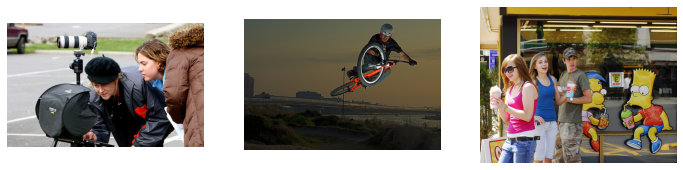

In [80]:
pred_lr_test('A guy in red on a bike in midair')

A white dog and a black dog in a field


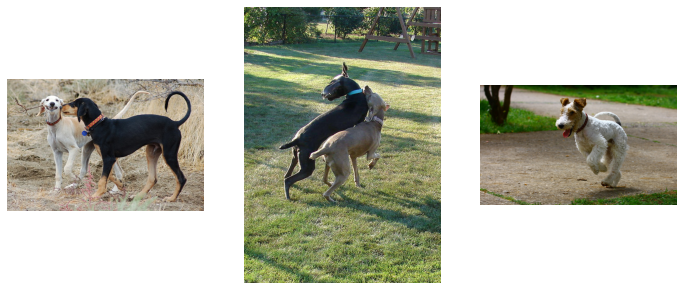

In [81]:
pred_lr_test('A white dog and a black dog in a field')

Two dogs run through a field


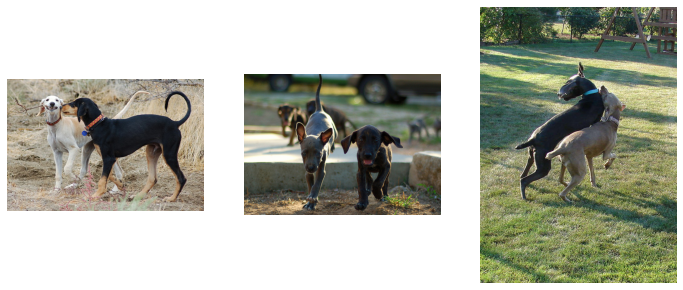

In [82]:
pred_lr_test('Two dogs run through a field')

A crowd of people at an outdoor event


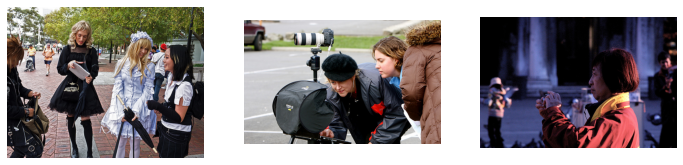

In [83]:
pred_lr_test('A crowd of people at an outdoor event')

### Тестирование нейросети

In [84]:
def pred_nn_test(text, ivecs=test_images, lim=3):
    if len(set(text.split()) & set(child_stop)) > 0:
        print ('This image is unavailable in your country in compliance with local laws')
    else:
        lemm_text = process_text(text)
        vector_from_text = tfvect.transform([lemm_text]).todense()
        tf_vect = tf.reshape(tf.convert_to_tensor(vector_from_text,dtype=np.float64),(1, text_vector_size))
        vec = tf.convert_to_tensor(nn_model.predict(tf_vect), dtype=np.float64)
        df = pd.DataFrame(ivecs)
        for i in df.index:
            df.loc[i, 'dist'] = vec_distance(vec, df.loc[i, 'image_vector'])
            images = df.sort_values(by='dist')['image'].unique()[:lim]
        show_images(text, images, test_path)

In [85]:
pred_nn_test('A child at home')

This image is unavailable in your country in compliance with local laws


In [86]:
pred_nn_test('A boy on cinema')

This image is unavailable in your country in compliance with local laws


In [87]:
pred_nn_test('A girl on tree')

This image is unavailable in your country in compliance with local laws


A guy in red on a bike in midair


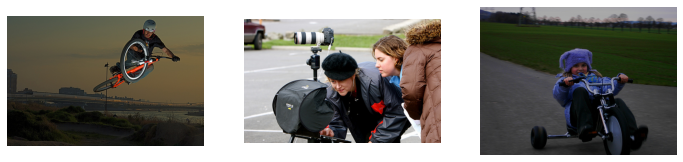

In [88]:
pred_nn_test('A guy in red on a bike in midair')

A white dog and a black dog in a field


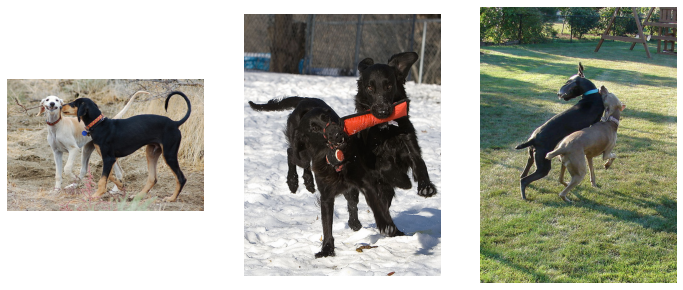

In [89]:
pred_nn_test('A white dog and a black dog in a field')

Two dogs run through a field


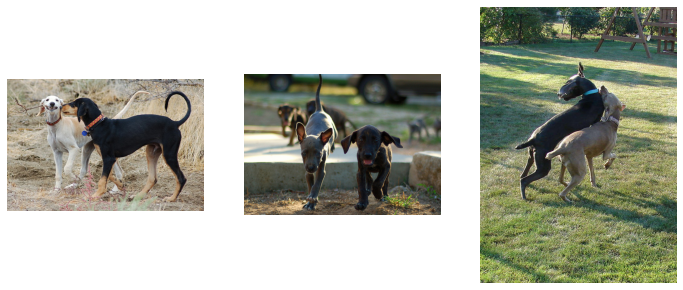

In [90]:
pred_nn_test('Two dogs run through a field')

A crowd of people at an outdoor event


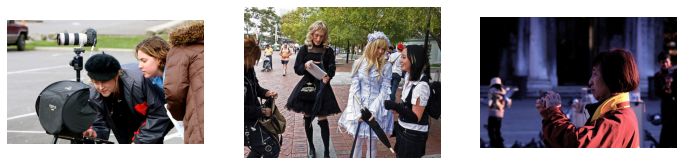

In [91]:
pred_nn_test('A crowd of people at an outdoor event')

## Вывод

Наши модели снова показали схожие результаты в прогнозировании изображений, и их успехи на тестовой выборке достаточно впечатляют.
В целом, концепция подтвердила свою жизнеспособность, но требует существенной доработки.
Возможные направления:
- Увеличение объема датасета может значительно улучшить результаты.
- Применение более глубокой нейронной сети с более тщательной настройкой гиперпараметров.
- Оценки сообщества не всегда точны и ценны, но они многочисленны. Было бы полезно разработать метод, как использовать их для улучшения точности моделей.



- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска